# Задача 5. Кластеризация

Поставлены следующие задачи:
- [X] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [X] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [ ] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [1]:
import os
import sys
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
from pathlib import Path

Был выбран датасет для классификации одежды. Оригинальные изображения предоставлены в слишком большом разрешении, поэтому при выполнении задания будут использоваться эти же изображения, но сжатые. Датасет можно найти по [ссылке](https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full).

## EDA

In [2]:
path_to_dataset_folder = Path("/home/alexander/clothes/")
csv_filename = path_to_dataset_folder / "images.csv"
csv_df = pd.read_csv(csv_filename)
csv_df.head(10)

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
5,5d3a1404-697f-479f-9090-c1ecd0413d27,138,Shorts,False
6,b0c03127-9dfb-4573-8934-1958396937bf,138,Shirt,False
7,4c8f245e-a039-46fd-a6b9-1bb51e83fc05,226,T-Shirt,False
8,c995c900-693d-4dd6-8995-43f3051ec488,337,Pants,False
9,bf78527f-0734-44fd-a968-f6c32c12d61e,175,Shoes,False


In [3]:
csv_df.shape

(5403, 4)

Для нашей задачи столбцы "sender_id" и "kids" не имеют никакой пользы, так что удалим их

In [4]:
csv_df = csv_df.dropna().drop_duplicates().drop(columns=["sender_id", "kids"])
csv_df.head(10)

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
5,5d3a1404-697f-479f-9090-c1ecd0413d27,Shorts
6,b0c03127-9dfb-4573-8934-1958396937bf,Shirt
7,4c8f245e-a039-46fd-a6b9-1bb51e83fc05,T-Shirt
8,c995c900-693d-4dd6-8995-43f3051ec488,Pants
9,bf78527f-0734-44fd-a968-f6c32c12d61e,Shoes


In [5]:
csv_df.shape

(5403, 2)

После удаления из данных столбцов, не имеющих значения для решаемой задачи, а также фильтрации данных (удаление дупликатов, отсутствующих данных)

In [6]:
labels = csv_df["label"].unique()
labels_num = len(labels)
print(labels, labels_num)

['Not sure' 'T-Shirt' 'Shoes' 'Shorts' 'Shirt' 'Pants' 'Skirt' 'Other'
 'Top' 'Outwear' 'Dress' 'Body' 'Longsleeve' 'Undershirt' 'Hat' 'Polo'
 'Blouse' 'Hoodie' 'Skip' 'Blazer'] 20


In [7]:
def is_valid_image(filename: Path):
    try:
        img = Image.open(filename)
        img.verify()
        return True
    except (IOError, SyntaxError, ValueError):
        return False

In [8]:
path_to_compressed_images = path_to_dataset_folder / "images_compressed"
invalid_images = []
for filename in os.listdir(path_to_compressed_images):
    if not is_valid_image(path_to_compressed_images / filename):
        invalid_images.append(filename)
invalid_images, len(invalid_images)

(['d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
  'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
  '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg',
  'b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
  '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg',
  '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg'],
 6)

In [9]:
invalid_image_indices: dict[str, int] = {}
for invalid_image in invalid_images:
    # Strip the file extension before comparing with the image column
    base_image_name = invalid_image.split(".")[0]
    index = csv_df.index[csv_df["image"] == base_image_name].tolist()
    if index:
        invalid_image_indices[base_image_name] = index[0]
    print(f"{invalid_image}: found indices {index}")

d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg: found indices [533]
c60e486d-10ed-4f64-abab-5bb698c736dd.jpg: found indices [1662]
040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg: found indices [1763]
b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg: found indices []
784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg: found indices [861]
1d0129a1-f29a-4a3f-b103-f651176183eb.jpg: found indices [703]


In [10]:
invalid_image_indices

{'d028580f-9a98-4fb5-a6c9-5dc362ad3f09': 533,
 'c60e486d-10ed-4f64-abab-5bb698c736dd': 1662,
 '040d73b7-21b5-4cf2-84fc-e1a80231b202': 1763,
 '784d67d4-b95e-4abb-baf7-8024f18dc3c8': 861,
 '1d0129a1-f29a-4a3f-b103-f651176183eb': 703}

In [11]:
def find_images_not_in_csv(image_dir, dataframe, image_column="image"):
    image_dir = Path(image_dir)
    missing_images = []

    # Get all image names from the dataframe
    csv_image_names = set(dataframe[image_column].values)

    # Check each file in the directory
    for filename in os.listdir(image_dir):
        base_name = filename.split(".")[0]  # Remove extension
        if base_name not in csv_image_names:
            missing_images.append(filename)

    return missing_images


# Find images in the compressed directory that aren't in the CSV
missing_in_csv = find_images_not_in_csv(path_to_compressed_images, csv_df)

Мы обнаружили, что 359 изображений отсутствуют в файле `images.csv`, который является аннотацией к датасету. Проверим, есть ли среди них невалидные изображения.

In [12]:
for invalid_image in invalid_images:
    print(invalid_image, invalid_image in missing_in_csv)

d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg False
c60e486d-10ed-4f64-abab-5bb698c736dd.jpg False
040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg False
b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg True
784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg False
1d0129a1-f29a-4a3f-b103-f651176183eb.jpg False


У нас в датасете есть 6 "битых" файлов. Такое количество достаточно мало по сравнению с общим количеством изображений (5398 изображений в аннотации, исключая невалидные изображения), поэтому мы можем ими пренебречь и удалить из датасета. Также у нас есть 359 изображений, которые не включены в файл `images.cvs`, поэтому ими так же придется пренебречь, если количество изображений разных классов останется сравнительно одинаковым. Проверим это.

Number of images per class:
label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64


/tmp/ipykernel_28295/4036356531.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")


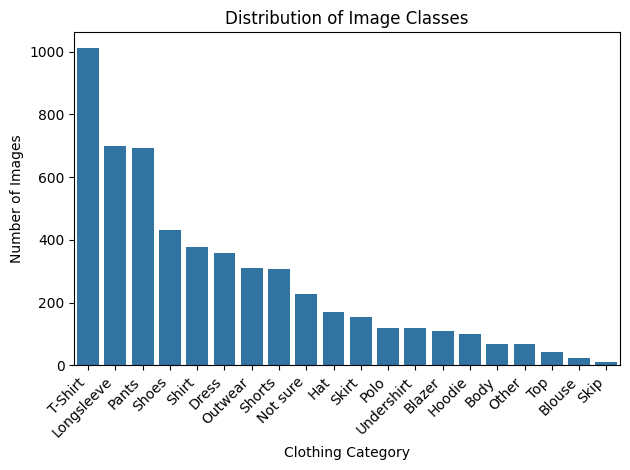

In [13]:
label_counts = csv_df["label"].value_counts()

print("Number of images per class:")
print(label_counts)

label_df = pd.DataFrame({"Category": label_counts.index, "Count": label_counts.values})

plot = sn.barplot(x="Category", y="Count", data=label_df)
plot.set_title("Distribution of Image Classes")
plot.set_xlabel("Clothing Category")
plot.set_ylabel("Number of Images")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")
plot.figure.tight_layout()

Количество изображений в разных классах сильно разнится, поэтому выделим 8 наиболее больших класса и установим 400 как максимальное количество изображений на класс.

/tmp/ipykernel_28295/2400437479.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")


Top 8 classes: ['T-Shirt', 'Longsleeve', 'Pants', 'Shoes', 'Shirt', 'Dress', 'Outwear', 'Shorts']

Filtered distribution:
label
Longsleeve    400
T-Shirt       400
Shoes         400
Pants         400
Shirt         378
Dress         357
Outwear       312
Shorts        308
Name: count, dtype: int64


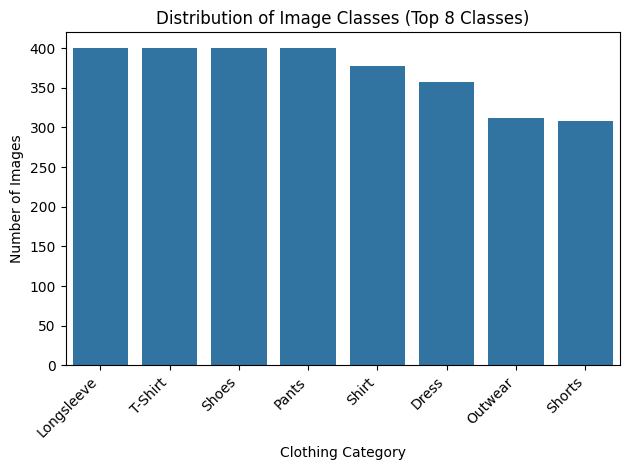

In [14]:
top_8_classes = label_counts.nlargest(8).index.tolist()
print("Top 8 classes:", top_8_classes)

max_samples = 400

filtered_df = pd.DataFrame()
for label in top_8_classes:
    class_data = csv_df[csv_df["label"] == label]

    if len(class_data) > max_samples:
        sampled_data = class_data.sample(max_samples, random_state=42)
    else:
        sampled_data = class_data

    filtered_df = pd.concat([filtered_df, sampled_data])

# Shuffle the filtered dataset
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

filtered_label_counts = filtered_df["label"].value_counts()
print("\nFiltered distribution:")
print(filtered_label_counts)

filtered_label_df = pd.DataFrame(
    {"Category": filtered_label_counts.index, "Count": filtered_label_counts.values}
)
plot = sn.barplot(x="Category", y="Count", data=filtered_label_df)
plot.set_title("Distribution of Image Classes (Top 8 Classes)")
plot.set_xlabel("Clothing Category")
plot.set_ylabel("Number of Images")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")
plot.figure.tight_layout()


In [15]:
filtered_df.shape

(2955, 2)

Удалим невалидные изображения, если они попали в новый датасет.

In [16]:
# Get the base names of invalid images (without extension)
invalid_base_names = [img.split(".")[0] for img in invalid_images]

# Check which invalid images are in the filtered dataset
invalid_in_filtered = filtered_df[filtered_df["image"].isin(invalid_base_names)]
print(f"Found {len(invalid_in_filtered)} invalid images in the filtered dataset:")

if len(invalid_in_filtered) > 0:
    print(invalid_in_filtered)

    # Remove invalid images from the filtered dataset
    cleaned_df = filtered_df[~filtered_df["image"].isin(invalid_base_names)]
    print(f"\nRemoved {len(filtered_df) - len(cleaned_df)} invalid images")
    print(f"Original shape: {filtered_df.shape}, New shape: {cleaned_df.shape}")

    # Verify the distribution of classes still looks good
    cleaned_label_counts = cleaned_df["label"].value_counts()
    print("\nUpdated class distribution:")
    print(cleaned_label_counts)

Found 0 invalid images in the filtered dataset:


Невалидные изображения не попали в новый датасет в нашем случае, но если выбирать иное значение `random seed` при выборе изображений в новый датасет, то они могут оказаться в результирующем датасете.

На данный момент у нас есть датасет, состоящий из 8 классов, в каждом из которых от 308 до 400 изображений, отсутствуют невалидные изображения. Проверим размеры изображений в датасете.

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


# Function to get image dimensions
def get_image_dimensions(image_name, image_dir=path_to_compressed_images):
    try:
        if not image_name.endswith(".jpg"):
            image_name = f"{image_name}.jpg"

        img_path = image_dir / image_name
        with Image.open(img_path) as img:
            return img.size  # Returns (width, height)
    except Exception as e:
        print(f"Error getting dimensions for {image_name}: {e}")
        return None

# Get dimensions for all images in the filtered dataset
print("Collecting image dimensions...")
dimensions = []
for idx, row in filtered_df.iterrows():
    dims = get_image_dimensions(row["image"])
    if dims is not None:
        dimensions.append(dims)

# Convert to numpy array for easier analysis
dimensions = np.array(dimensions)

# Get basic statistics
widths = dimensions[:, 0]
heights = dimensions[:, 1]
aspect_ratios = widths / heights

print(f"\nTotal images analyzed: {len(dimensions)}")
print(f"Width range: {widths.min()} to {widths.max()} pixels")
print(f"Height range: {heights.min()} to {heights.max()} pixels")
print(f"Mean dimensions: {widths.mean():.1f} x {heights.mean():.1f} pixels")
print(f"Median dimensions: {np.median(widths)} x {np.median(heights)} pixels")
print(f"Mean aspect ratio: {aspect_ratios.mean():.2f}")

# Count unique dimensions
unique_dims = Counter([(w, h) for w, h in dimensions])
most_common_dims = unique_dims.most_common(10)
print("\nMost common dimensions (width x height):")
for (w, h), count in most_common_dims:
    print(f"{w} x {h}: {count} images ({count / len(dimensions) * 100:.1f}%)")


Total images analyzed: 2955
Width range: 400 to 867 pixels
Height range: 400 to 936 pixels
Mean dimensions: 422.8 x 519.0 pixels
Median dimensions: 400.0 x 533.0 pixels
Mean aspect ratio: 0.85

Most common dimensions (width x height):
400 x 533: 1278 images (43.2%)
400 x 534: 601 images (20.3%)
533 x 400: 209 images (7.1%)
400 x 711: 178 images (6.0%)
534 x 400: 78 images (2.6%)
400 x 400: 60 images (2.0%)
711 x 400: 44 images (1.5%)
400 x 532: 20 images (0.7%)
400 x 712: 16 images (0.5%)
400 x 710: 9 images (0.3%)


Можно заметить, что изображения в датасете обладают разным разрешением в большинстве случаев. Минимальная высота изображения в датасете - 400px, ширина - 400px. Приведем все изображения к размеру 400x400.

In [24]:
# Define a standard size for all images
target_size = (400, 400)


# Function to load and resize an image
def load_and_resize_image(image_name, target_size=target_size):
    try:
        if not image_name.endswith(".jpg"):
            image_name = f"{image_name}.jpg"
        img_path = path_to_compressed_images / image_name
        img = Image.open(img_path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        img_resized = img.resize(target_size, Image.LANCZOS)
        img_array = np.array(img_resized)
        return img_array

    except Exception as e:
        print(f"Error loading image {image_name}: {e}")
        return None


# Create a dataset with resized images
print("\nResizing all images to", target_size)
X_resized = []
y_labels = []

for idx, row in filtered_df.iterrows():
    img_array = load_and_resize_image(row["image"])
    if img_array is not None:
        X_resized.append(img_array)
        y_labels.append(row["label"])

# Convert lists to numpy arrays
X_resized = np.array(X_resized)
y_labels = np.array(y_labels)

# Check the shape of the resulting dataset
print(f"\nResized dataset shape: {X_resized.shape}")
print(f"Number of labels: {len(y_labels)}")


Resizing all images to (400, 400)

Resized dataset shape: (2955, 400, 400, 3)
Number of labels: 2955


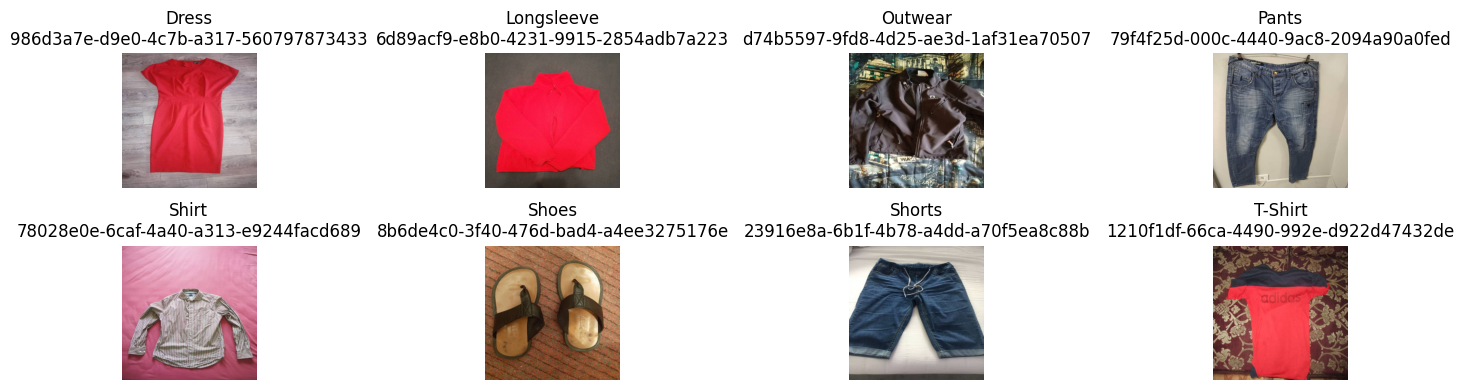

In [25]:
# Show one sample image per class
unique_classes = np.unique(y_labels)

plt.figure(figsize=(16, 4))
for i, class_name in enumerate(unique_classes):
    # Find the first index of this class
    idx = np.where(y_labels == class_name)[0][0]

    plt.subplot(2, 4, i + 1)
    plt.imshow(X_resized[idx])
    plt.title(class_name + f"\n{filtered_df['image'][idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


После приведения изображений к единому разрешению, они не потеряли визуальные признаки, характерные для их классов. Все изображения остались валидными, количество не изменилось. Изображения в `X_resized` располагаются в таком же порядке, как и в `filtered_df`.

Итого:
- Был выбран датасет
- Были обнаружены проблемы с невалидными изображениями
- Были обнаружены проблемы с несоответствующим количеством изображений, описанных в аннотации и присутствующих в самом датасете
- Были выбраны **8** наиболее больших классов (содержат наибольшее количество экземпляров)
- В них были включены только изображения, описанные в аннотации
- Количество изображений в классах было ограничено сверху границей в **400** изображений, чтобы привести количество изображений в классах к приблизительно одинаковому количеству
- Итоговое количество изображений в новом собранном датасете $-$ **2955**
- Были исследованы размеры изображений в новом датасете
- Все изображения в новом датасете были приведены к единому размеру **400x400**

## Собственная реализация `K-Means`